In [1]:
!pwd

/Users/ashish1610dhiman/data_projects/fall22_hw/RoboChef/notebooks/recommendation


In [9]:
import pandas as pd
from surprise import Dataset
from surprise import Reader

from surprise import accuracy, Dataset, SVD
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split

import numpy as np

### Read Provided Train Test validation

In [3]:
train_set = pd.read_csv("../../data/recommendation/interactions_train.csv")
test_set = pd.read_csv("../../data/recommendation/interactions_test.csv")
validation_set = pd.read_csv("../../data/recommendation/interactions_validation.csv")
train_set.shape, test_set.shape, validation_set.shape

((698901, 6), (12455, 6), (7023, 6))

In [4]:
698901+12455+7023

718379

In [6]:
raw_interactions = pd.read_csv("../../data/recommendation/RAW_interactions.csv")
raw_interactions.shape

(1132367, 5)

### Create Train/Test/validation from raw

In [13]:
TRAIN__Validation_SIZE = 0.8
TEST_SIZE = 0.2

In [42]:
train_validation, test_set = train_test_split(raw_interactions, test_size=TEST_SIZE)
train_validation.shape, test_set.shape

((905893, 5), (226474, 5))

In [43]:
905893 + 226474

1132367

### Train SVD matrix Factorisation

In [50]:
reader = Reader(rating_scale=(1, 5))
cv_data = Dataset.load_from_df(train_validation[["user_id", "recipe_id", "rating"\
                                                                           ]], reader)

In [58]:
param_grid = {"n_factors":[20, 50] ,"n_epochs": [10, 15], "lr_all": [0.002, 0.005]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=5, n_jobs = -2)

gs.fit(cv_data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

print(gs.best_params["mae"])

1.218094140876164
{'n_factors': 20, 'n_epochs': 15, 'lr_all': 0.005}
{'n_factors': 20, 'n_epochs': 15, 'lr_all': 0.005}


In [59]:
cv_results_df = pd.DataFrame.from_dict(gs.cv_results)
cv_results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all
0,1.228697,1.222297,1.223658,1.224391,1.227176,1.225244,0.002349,7,0.753424,0.750137,...,0.001077,7,3.104795,0.285593,2.142331,0.043642,"{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0....",20,10,0.002
1,1.222545,1.216202,1.217771,1.218116,1.220700,1.219067,0.002261,2,0.745213,0.742198,...,0.001041,3,3.418055,0.057300,2.247503,0.112610,"{'n_factors': 20, 'n_epochs': 10, 'lr_all': 0....",20,10,0.005
2,1.225618,1.219103,1.220609,1.221104,1.223918,1.222070,0.002361,5,0.748299,0.744931,...,0.001136,5,5.038678,0.246600,2.584927,0.124022,"{'n_factors': 20, 'n_epochs': 15, 'lr_all': 0....",20,15,0.002
3,1.221387,1.215518,1.216680,1.217148,1.219737,1.218094,0.002148,1,0.742132,0.739437,...,0.000949,1,5.407024,0.045598,2.592297,0.112011,"{'n_factors': 20, 'n_epochs': 15, 'lr_all': 0....",20,15,0.005
4,1.229484,1.223111,1.224706,1.225294,1.227844,1.226088,0.002281,8,0.753773,0.750606,...,0.001036,8,5.595094,0.050464,2.665056,0.189076,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.002
5,1.223622,1.217173,1.219072,1.219182,1.221810,1.220172,0.002270,4,0.745916,0.742958,...,0.001079,4,5.840886,0.037470,2.945850,0.388703,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0....",50,10,0.005
6,1.226369,1.220202,1.221285,1.221693,1.224812,1.222872,0.002325,6,0.748669,0.745687,...,0.001095,6,9.108575,0.297556,2.598949,0.253296,"{'n_factors': 50, 'n_epochs': 15, 'lr_all': 0....",50,15,0.002
7,1.222967,1.216686,1.218197,1.218461,1.220920,1.219446,0.002223,3,0.743177,0.740046,...,0.001130,2,7.053559,0.782029,1.927421,0.273523,"{'n_factors': 50, 'n_epochs': 15, 'lr_all': 0....",50,15,0.005


### Test RMSE

In [60]:
#Build model on full cv set
algo = gs.best_estimator["rmse"]
algo.fit(cv_data.build_full_trainset())

In [67]:
test_set_surprise = Dataset.load_from_df(test_set[["user_id", "recipe_id", "rating"]], reader)
_, test_set_surprise = train_test_split_surprise(test_set_surprise, test_size=1.0)

In [68]:
len(test_set_surprise)

226474

In [111]:
test_set_surprise[:5]

[(1165172, 288612, 5.0),
 (1208812, 321647, 5.0),
 (72428, 56564, 5.0),
 (279833, 88413, 5.0),
 (56251, 142909, 5.0)]

In [69]:
predictions = algo.test(test_set_surprise)
accuracy.rmse(predictions, verbose=True)

RMSE: 1.2117


1.2117454568213044

### Analyse the latent features

In [83]:
algo.trainset.n_users, algo.trainset.n_items

(192203, 211175)

In [79]:
user_matrix = algo.pu
user_matrix.shape

(192203, 20)

In [80]:
movie_matrix = algo.qi
movie_matrix.shape

(211175, 20)

In [85]:
movie_matrix

array([[ 0.09524442, -0.1510456 ,  0.14623887, ...,  0.11218057,
        -0.29064038, -0.22301917],
       [ 0.11689985,  0.10760133,  0.01638914, ...,  0.14484605,
         0.01570842, -0.12526542],
       [ 0.1346034 , -0.02673584, -0.12403986, ...,  0.07421647,
         0.10532164, -0.05564857],
       ...,
       [-0.02843258, -0.08129328,  0.0061126 , ..., -0.05580581,
        -0.05151654, -0.07984464],
       [-0.01450603, -0.07436843,  0.11941567, ...,  0.01273909,
         0.09906085,  0.04247613],
       [ 0.16088051,  0.31459155,  0.11845598, ..., -0.06658918,
         0.00126287, -0.09816173]])

In [112]:
cv_data

In [126]:
movie_mat_df = pd.DataFrame(movie_matrix)
movie_mat_df.columns = [f"latent_{i+1}" for i in range(len(movie_mat_df.columns))]
movie_mat_df["recipe_id"] = cv_data.df.recipe_id

In [127]:
recipe_metadata = pd.read_csv("../../data/recommendation/RAW_recipes.csv")
recipe_metadata.shape

(231637, 12)

In [128]:
recipe_metadata.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [129]:
movie_mat_join_recipe_meta = recipe_metadata.merge(movie_mat_df,left_on = "id",\
                                                 right_on = "recipe_id")
movie_mat_join_recipe_meta.shape

(168969, 33)

In [132]:
latent_cols = [x for x in movie_mat_join_recipe_meta.columns if "latent" in x]
latent_cols

['latent_1',
 'latent_2',
 'latent_3',
 'latent_4',
 'latent_5',
 'latent_6',
 'latent_7',
 'latent_8',
 'latent_9',
 'latent_10',
 'latent_11',
 'latent_12',
 'latent_13',
 'latent_14',
 'latent_15',
 'latent_16',
 'latent_17',
 'latent_18',
 'latent_19',
 'latent_20']

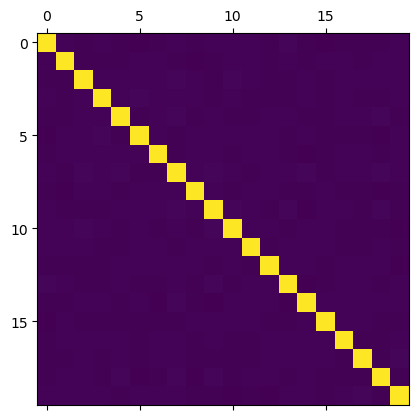

In [139]:
import matplotlib.pyplot as plt

plt.matshow(movie_mat_join_recipe_meta[latent_cols].corr())
plt.show()

In [153]:
def _my_corr(x):
    df_corr = movie_mat_join_recipe_meta[[x,"minutes","n_ingredients","n_steps"]].corr()
    df_corr = df_corr.drop(columns = [x]).iloc[:1]
    return (df_corr)

In [159]:
_my_corr(latent_i)

,minutes,n_ingredients,n_steps
latent_20,-0.000754,-0.001033,0.00078


In [161]:
corr_result = pd.DataFrame()
for latent_i in latent_cols:
    corr_result = pd.concat([corr_result,_my_corr(latent_i)],axis=0)

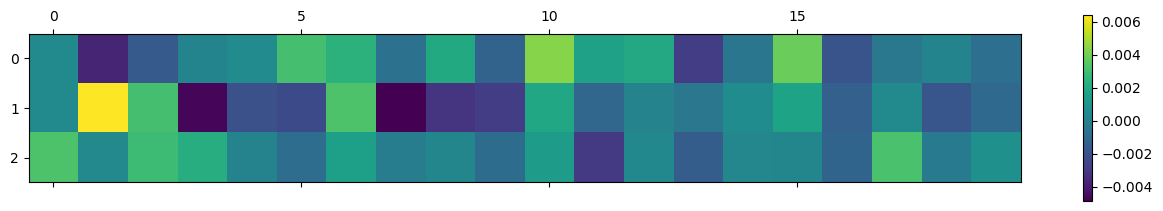

In [164]:
plt.matshow(corr_result.T)
cb = plt.colorbar()
plt.show()

In [165]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1)
recipe_embedding = tsne.fit_transform(movie_matrix)
projection = pd.DataFrame(columns=['x', 'y'], data=recipe_embedding)
# projection['title'] = books_metadata['original_title']

/Users/ashish1610dhiman/opt/anaconda3/envs/ml_project_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ashish1610dhiman/opt/anaconda3/envs/ml_project_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 211175 samples in 0.003s...
[t-SNE] Computed neighbors for 211175 samples in 915.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 211175
[t-SNE] Computed conditional probabilities for sample 2000 / 211175
[t-SNE] Computed conditional probabilities for sample 3000 / 211175
[t-SNE] Computed conditional probabilities for sample 4000 / 211175
[t-SNE] Computed conditional probabilities for sample 5000 / 211175
[t-SNE] Computed conditional probabilities for sample 6000 / 211175
[t-SNE] Computed conditional probabilities for sample 7000 / 211175
[t-SNE] Computed conditional probabilities for sample 8000 / 211175
[t-SNE] Computed conditional probabilities for sample 9000 / 211175
[t-SNE] Computed conditional probabilities for sample 10000 / 211175
[t-SNE] Computed conditional probabilities for sample 11000 / 211175
[t-SNE] Computed conditional probabilities for sample 12000 / 211175
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 127000 / 211175
[t-SNE] Computed conditional probabilities for sample 128000 / 211175
[t-SNE] Computed conditional probabilities for sample 129000 / 211175
[t-SNE] Computed conditional probabilities for sample 130000 / 211175
[t-SNE] Computed conditional probabilities for sample 131000 / 211175
[t-SNE] Computed conditional probabilities for sample 132000 / 211175
[t-SNE] Computed conditional probabilities for sample 133000 / 211175
[t-SNE] Computed conditional probabilities for sample 134000 / 211175
[t-SNE] Computed conditional probabilities for sample 135000 / 211175
[t-SNE] Computed conditional probabilities for sample 136000 / 211175
[t-SNE] Computed conditional probabilities for sample 137000 / 211175
[t-SNE] Computed conditional probabilities for sample 138000 / 211175
[t-SNE] Computed conditional probabilities for sample 139000 / 211175
[t-SNE] Computed conditional probabilities for sample 140000 / 211175
[t-SNE] Computed con

In [171]:
projection.head()

,x,y
0,4.540770e-07,-1.228143e-06
1,1.107355e-06,8.735510e-07
2,-4.192752e-07,4.332632e-07
3,7.956787e-07,5.327870e-07
4,4.981666e-06,2.388648e-06


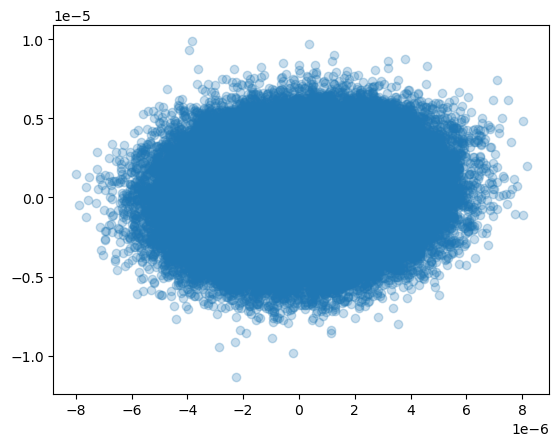

In [176]:
plt.scatter(projection["x"],projection["y"],alpha = 0.25)

train_validation, test_set = train_test_split_surprise(full_data, test_size=0.15)

train_validation.n_ratings, len(test_set), train_validation.n_ratings + len(test_set)

train_validation.n_items, train_validation.n_users

### Build SVD Matrix Factorisation

svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, train_validation, measures=['RMSE', 'MAE'], cv=10, verbose=True)

dir(train_validation)